<a href="https://colab.research.google.com/github/yoboiwatsup/MachineLearning/blob/main/Week%2014/RNN_dan_Deep_RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

# Upload dataset
from google.colab import files
uploaded = files.upload()

# Membaca dataset
df = pd.read_csv('Iris.csv')

# Memeriksa dataset
print("Dataset Head:\n", df.head())
print("\nInfo Dataset:\n", df.info())

# Menghapus kolom yang tidak relevan jika ada
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

# Encode label target (Species)
label_encoder = LabelEncoder()
df['Species'] = label_encoder.fit_transform(df['Species'])

# Memisahkan fitur dan target
X = df.drop(columns=['Species']).values
y = df['Species'].values

# Standarisasi fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi data ke Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Membuat DataLoader
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IrisDataset(X_train_tensor, y_train_tensor)
test_dataset = IrisDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Saving Iris.csv to Iris (1).csv
Dataset Head:
    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), objec

In [34]:
# Definisi model RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Menginisialisasi hidden state dengan nilai nol
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # Forward pass melalui RNN
        out, _ = self.rnn(x, h0)
        # Mengambil output dari waktu terakhir (last time step)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Hyperparameter awal
input_size = X_train_tensor.shape[1]  # Jumlah fitur
hidden_size = 32  # Bisa divariasikan
num_classes = len(np.unique(y))  # Jumlah kelas
learning_rate = 0.01

# Inisialisasi model
model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RNNModel(
  (rnn): RNN(4, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [35]:
# Fungsi untuk melatih model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Reset gradien
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch.unsqueeze(1))  # Tambahkan dimensi batch
            loss = criterion(outputs, y_batch)

            # Backward pass dan optimasi
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# Latih model dengan 5 epoch sebagai percobaan awal
num_epochs = 5
train_model(model, train_loader, criterion, optimizer, num_epochs)


Epoch [1/5], Loss: 0.9249
Epoch [2/5], Loss: 0.5644
Epoch [3/5], Loss: 0.3988
Epoch [4/5], Loss: 0.3067
Epoch [5/5], Loss: 0.2638


In [36]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluasi model
evaluate_model(model, test_loader)


Accuracy: 96.67%


96.66666666666667

In [37]:
# Fungsi untuk menguji berbagai hidden size
hidden_sizes = [16, 32, 64, 128]
hidden_size_results = {}

for hs in hidden_sizes:
    print(f"\nTraining model with hidden size: {hs}")

    # Inisialisasi model dengan hidden size yang berbeda
    model = RNNModel(input_size=input_size, hidden_size=hs, num_classes=num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Latih model
    train_model(model, train_loader, criterion, optimizer, num_epochs=5)

    # Evaluasi model
    accuracy = evaluate_model(model, test_loader)
    hidden_size_results[hs] = accuracy

# Tampilkan hasil perbandingan
print("\nHidden Size Results:")
for hs, acc in hidden_size_results.items():
    print(f"Hidden Size: {hs}, Accuracy: {acc:.2f}%")



Training model with hidden size: 16
Epoch [1/5], Loss: 0.9283
Epoch [2/5], Loss: 0.6429
Epoch [3/5], Loss: 0.4794
Epoch [4/5], Loss: 0.3877
Epoch [5/5], Loss: 0.3331
Accuracy: 93.33%

Training model with hidden size: 32
Epoch [1/5], Loss: 0.9063
Epoch [2/5], Loss: 0.5242
Epoch [3/5], Loss: 0.3499
Epoch [4/5], Loss: 0.2879
Epoch [5/5], Loss: 0.2369
Accuracy: 96.67%

Training model with hidden size: 64
Epoch [1/5], Loss: 0.8004
Epoch [2/5], Loss: 0.4008
Epoch [3/5], Loss: 0.3101
Epoch [4/5], Loss: 0.2487
Epoch [5/5], Loss: 0.1761
Accuracy: 100.00%

Training model with hidden size: 128
Epoch [1/5], Loss: 0.7488
Epoch [2/5], Loss: 0.3359
Epoch [3/5], Loss: 0.2504
Epoch [4/5], Loss: 0.1843
Epoch [5/5], Loss: 0.1399
Accuracy: 96.67%

Hidden Size Results:
Hidden Size: 16, Accuracy: 93.33%
Hidden Size: 32, Accuracy: 96.67%
Hidden Size: 64, Accuracy: 100.00%
Hidden Size: 128, Accuracy: 96.67%


In [38]:
class RNNWithPooling(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, pooling_type='max'):
        super(RNNWithPooling, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.pooling_type = pooling_type
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)

        # Apply pooling
        if self.pooling_type == 'max':
            out, _ = torch.max(out, dim=1)
        elif self.pooling_type == 'avg':
            out = torch.mean(out, dim=1)

        out = self.fc(out)
        return out

In [39]:
# Bandingkan MaxPooling dan AvgPooling
pooling_types = ['max', 'avg']
pooling_results = {}

for pooling in pooling_types:
    print(f"\nTraining model with {pooling} pooling")

    model = RNNWithPooling(input_size=input_size, hidden_size=32, num_classes=num_classes, pooling_type=pooling)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, train_loader, criterion, optimizer, num_epochs=5)
    accuracy = evaluate_model(model, test_loader)
    pooling_results[pooling] = accuracy

# Tampilkan hasil perbandingan
print("\nPooling Results:")
for pooling, acc in pooling_results.items():
    print(f"Pooling: {pooling}, Accuracy: {acc:.2f}%")



Training model with max pooling
Epoch [1/5], Loss: 0.9467
Epoch [2/5], Loss: 0.5445
Epoch [3/5], Loss: 0.3795
Epoch [4/5], Loss: 0.3055
Epoch [5/5], Loss: 0.2719
Accuracy: 93.33%

Training model with avg pooling
Epoch [1/5], Loss: 0.7837
Epoch [2/5], Loss: 0.4995
Epoch [3/5], Loss: 0.3744
Epoch [4/5], Loss: 0.3012
Epoch [5/5], Loss: 0.2418
Accuracy: 96.67%

Pooling Results:
Pooling: max, Accuracy: 93.33%
Pooling: avg, Accuracy: 96.67%


In [40]:
# Early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Fungsi untuk melatih model dengan Early Stopping dan Scheduler
def train_with_callbacks(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
    model.train()
    early_stopper = EarlyStopping(patience=10)
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validasi dan penjadwalan learning rate
        val_loss = sum(criterion(model(X_test_tensor.unsqueeze(1).to(device)), y_test_tensor.to(device)).item() for _ in test_loader) / len(test_loader)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break


In [41]:
# Konfigurasi Learning Rate Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs_list = [5, 50, 100, 250, 350]
epoch_results = {}

for epochs in num_epochs_list:
    print(f"\nTraining with {epochs} epochs:")

    model = RNNModel(input_size=input_size, hidden_size=32, num_classes=num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

    train_with_callbacks(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=epochs)
    accuracy = evaluate_model(model, test_loader)
    epoch_results[epochs] = accuracy

# Tampilkan hasil
print("\nEpoch Results:")
for epochs, acc in epoch_results.items():
    print(f"Epochs: {epochs}, Accuracy: {acc:.2f}%")



Training with 5 epochs:
Epoch [1/5], Train Loss: 0.8869, Val Loss: 0.5709


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [2/5], Train Loss: 0.5010, Val Loss: 0.3676
Epoch [3/5], Train Loss: 0.3670, Val Loss: 0.2785
Epoch [4/5], Train Loss: 0.3185, Val Loss: 0.2259
Epoch [5/5], Train Loss: 0.2587, Val Loss: 0.1758
Accuracy: 100.00%

Training with 50 epochs:
Epoch [1/50], Train Loss: 0.9570, Val Loss: 0.6845
Epoch [2/50], Train Loss: 0.5575, Val Loss: 0.3971
Epoch [3/50], Train Loss: 0.3960, Val Loss: 0.2781
Epoch [4/50], Train Loss: 0.3001, Val Loss: 0.2121
Epoch [5/50], Train Loss: 0.2411, Val Loss: 0.1643
Epoch [6/50], Train Loss: 0.2138, Val Loss: 0.1289
Epoch [7/50], Train Loss: 0.1779, Val Loss: 0.1036
Epoch [8/50], Train Loss: 0.1395, Val Loss: 0.1063
Epoch [9/50], Train Loss: 0.1237, Val Loss: 0.0804
Epoch [10/50], Train Loss: 0.1084, Val Loss: 0.0746
Epoch [11/50], Train Loss: 0.0871, Val Loss: 0.0698
Epoch [12/50], Train Loss: 0.0890, Val Loss: 0.0628
Epoch [13/50], Train Loss: 0.0770, Val Loss: 0.0629
Epoch [14/50], Train Loss: 0.0785, Val Loss: 0.0526
Epoch [15/50], Train Loss: 0.0673, Va

In [42]:
optimizers = {
    "SGD": optim.SGD,
    "RMSProp": optim.RMSprop,
    "Adam": optim.Adam
}

optimizer_results = {}

for opt_name, opt_class in optimizers.items():
    print(f"\nTraining with optimizer: {opt_name}")

    model = RNNModel(input_size=input_size, hidden_size=32, num_classes=num_classes)
    model.to(device)
    optimizer = opt_class(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

    train_with_callbacks(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50)
    accuracy = evaluate_model(model, test_loader)
    optimizer_results[opt_name] = accuracy

# Tampilkan hasil
print("\nOptimizer Results:")
for opt_name, acc in optimizer_results.items():
    print(f"Optimizer: {opt_name}, Accuracy: {acc:.2f}%")



Training with optimizer: SGD
Epoch [1/50], Train Loss: 1.1212, Val Loss: 1.0998
Epoch [2/50], Train Loss: 1.0737, Val Loss: 1.0567
Epoch [3/50], Train Loss: 1.0432, Val Loss: 1.0170
Epoch [4/50], Train Loss: 1.0000, Val Loss: 0.9793
Epoch [5/50], Train Loss: 0.9685, Val Loss: 0.9442
Epoch [6/50], Train Loss: 0.9398, Val Loss: 0.9113
Epoch [7/50], Train Loss: 0.9037, Val Loss: 0.8798
Epoch [8/50], Train Loss: 0.8778, Val Loss: 0.8500
Epoch [9/50], Train Loss: 0.8447, Val Loss: 0.8213
Epoch [10/50], Train Loss: 0.8238, Val Loss: 0.7945
Epoch [11/50], Train Loss: 0.7826, Val Loss: 0.7683
Epoch [12/50], Train Loss: 0.7689, Val Loss: 0.7441
Epoch [13/50], Train Loss: 0.7497, Val Loss: 0.7212
Epoch [14/50], Train Loss: 0.7226, Val Loss: 0.6992
Epoch [15/50], Train Loss: 0.7077, Val Loss: 0.6792
Epoch [16/50], Train Loss: 0.6819, Val Loss: 0.6600
Epoch [17/50], Train Loss: 0.6736, Val Loss: 0.6424
Epoch [18/50], Train Loss: 0.6420, Val Loss: 0.6258
Epoch [19/50], Train Loss: 0.6460, Val Loss

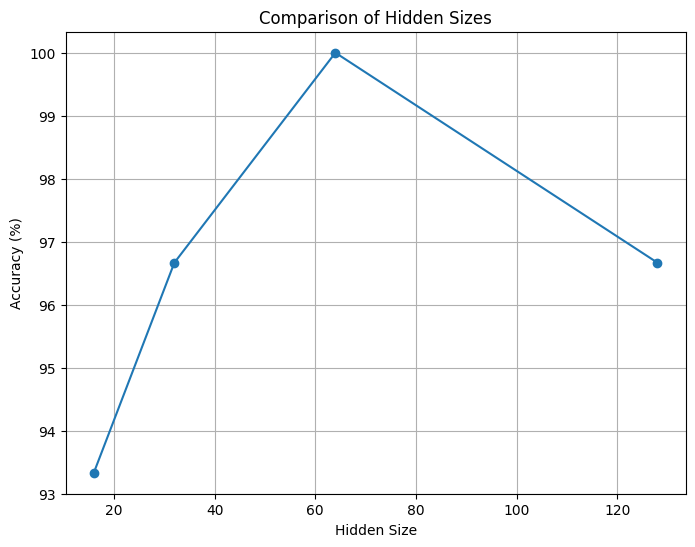

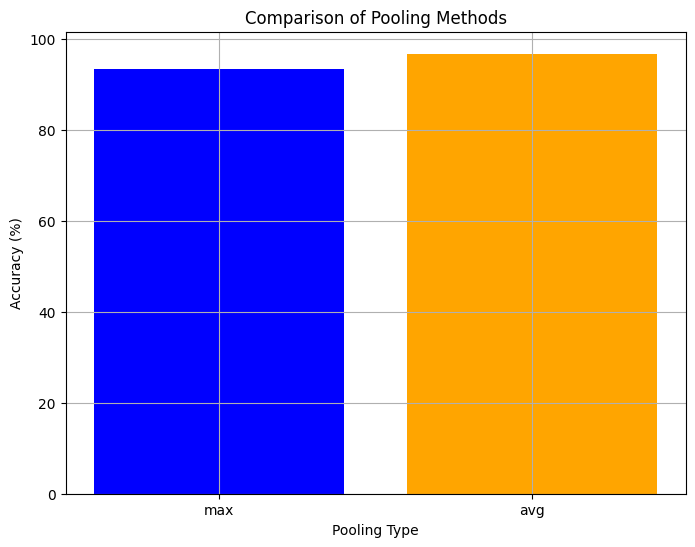

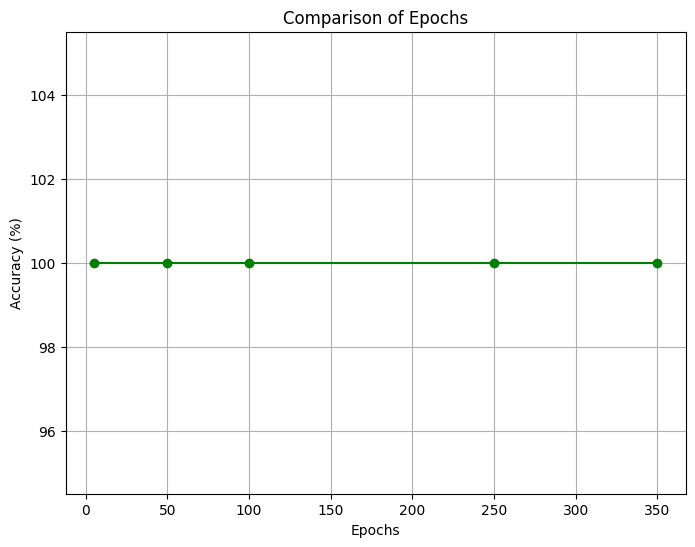

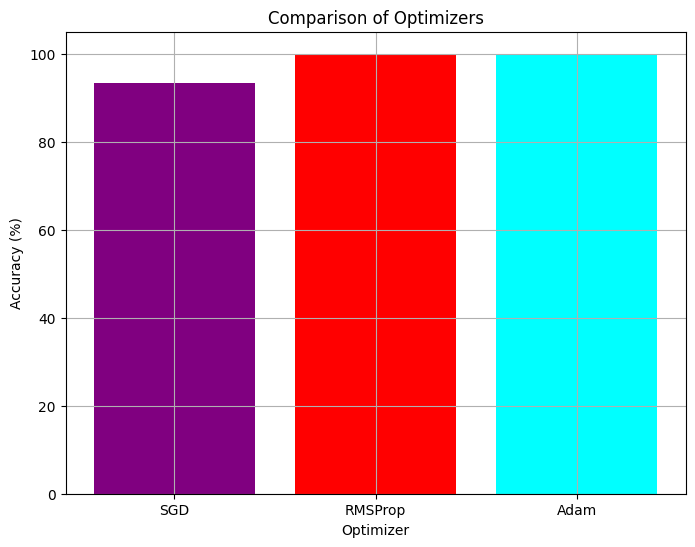

In [43]:
import matplotlib.pyplot as plt

# Visualisasi hasil perbandingan Hidden Size
hidden_sizes = list(hidden_size_results.keys())
accuracies = list(hidden_size_results.values())

plt.figure(figsize=(8, 6))
plt.plot(hidden_sizes, accuracies, marker='o')
plt.title('Comparison of Hidden Sizes')
plt.xlabel('Hidden Size')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()

# Visualisasi hasil perbandingan Pooling
pooling_types = list(pooling_results.keys())
pooling_accuracies = list(pooling_results.values())

plt.figure(figsize=(8, 6))
plt.bar(pooling_types, pooling_accuracies, color=['blue', 'orange'])
plt.title('Comparison of Pooling Methods')
plt.xlabel('Pooling Type')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()

# Visualisasi hasil perbandingan Epochs
epochs = list(epoch_results.keys())
epoch_accuracies = list(epoch_results.values())

plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_accuracies, marker='o', color='green')
plt.title('Comparison of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()

# Visualisasi hasil perbandingan Optimizers
optimizers = list(optimizer_results.keys())
optimizer_accuracies = list(optimizer_results.values())

plt.figure(figsize=(8, 6))
plt.bar(optimizers, optimizer_accuracies, color=['purple', 'red', 'cyan'])
plt.title('Comparison of Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()
